This was one of my first attempts at modeling neural networks. I compare the accuracy of the Sentiment Intensity Analyzer from nltk with a RNN I modeled using tensorflow. I found that the RNN had a better accuracy and was even able to give good predictions for custom prompts I gave it. I plan to do research at UIUC to with LLM development and this experience was helpful to prepare myself with skills and knowledge of sentiment analysis and nlp. For this project, I use a subset (25000 observations) of the full dataset (~ 195000 observations) for quicker computation time. But I would imagine better accuracy using the full dataset. I have been using various online resources in my independent project-based learning journey. Here, I found geeksforgeeks to be very helpful in my learning and understanding of this topic and technical implementation. 

In [402]:
#imports
import pandas as pd
import numpy as np
import json
import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences 
from sklearn.model_selection import train_test_split 
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Embedding, BatchNormalization 
from tensorflow.keras.models import Sequential 


### Lexicon-based analysis

In [403]:
#loading in data
df = pd.read_json('AmazonReviews.json', lines=True)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"
1,ASY55RVNIL0UD,120401325X,emily l.,"[0, 0]",These stickers work like the review says they ...,5,Really great product.,1389657600,"01 14, 2014"
2,A2TMXE2AFO7ONB,120401325X,Erica,"[0, 0]",These are awesome and make my phone look so st...,5,LOVE LOVE LOVE,1403740800,"06 26, 2014"
3,AWJ0WZQYMYFQ4,120401325X,JM,"[4, 4]",Item arrived in great time and was in perfect ...,4,Cute!,1382313600,"10 21, 2013"
4,ATX7CZYFXI1KW,120401325X,patrice m rogoza,"[2, 3]","awesome! stays on, and looks great. can be use...",5,leopard home button sticker for iphone 4s,1359849600,"02 3, 2013"


In [404]:
#Evaluating size of data
df.shape

(194439, 9)

In [405]:
df = df[['reviewText','overall']].sample(25000, random_state= 0)
df.head()

,reviewText,overall
96435,Like the case just cant charge my phone while ...,3
37878,I researched a lot on the web and this was the...,5
159708,They work just fine and they were inexpensive....,5
34742,I absolutely love this phone case! I've bought...,5
78487,This headset is perfect for use while I'm driv...,5


In [406]:
#checking null values
print(df.isna().sum())

reviewText    0
overall       0
dtype: int64


In [407]:
def tokenize_and_filter(text):
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stopwords.words('english')]  # Remove stopwords and non-alphanumeric tokens
    return filtered_tokens

df['reviewText'] = df['reviewText'].apply(tokenize_and_filter)

df.head()

,reviewText,overall
96435,"[like, case, cant, charge, phone, case]",3
37878,"[researched, lot, web, best, rated, product, d...",5
159708,"[work, fine, inexpensive, keeping, handy, need...",5
34742,"[absolutely, love, phone, case, bought, 2, oth...",5
78487,"[headset, perfect, use, driving, able, answer,...",5


In [408]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens] #lemmatizing

df['reviewText'] = df['reviewText'].apply(lemmatize_tokens)

df.head()

,reviewText,overall
96435,"[like, case, cant, charge, phone, case]",3
37878,"[researched, lot, web, best, rated, product, d...",5
159708,"[work, fine, inexpensive, keeping, handy, need...",5
34742,"[absolutely, love, phone, case, bought, 2, oth...",5
78487,"[headset, perfect, use, driving, able, answer,...",5


In [409]:
analyzer = SentimentIntensityAnalyzer() #utilizing nltk's Sentiment Intensity Analyzer tool to determine sentiment

def sentiment(text):
    text = ' '.join(text)
    scores = analyzer.polarity_scores(text)
    return round((scores['compound'] + 1) * (5/2)) #transforming the original -1 to 1 scale to match the 0-5 scale of Amazon

df['sentiment'] = df['reviewText'].apply(sentiment)

df.sample(5, random_state= 999) #Checking how the sentiment from the SIA compares to the actual overall user rating

,reviewText,overall,sentiment
42284,"[bad, ca, rate, something, le, one, junk, fit,...",1,1
172424,"[atlas, headphone, high, mids, low, far, sound...",5,5
137047,"[superior, product, come, total, package, woul...",5,4
18159,"[cover, thick, touch, screen, work, put, buy]",1,2
54700,"[nice, phone, good, feature, solid, large, bol...",3,5


In [410]:
from sklearn.metrics import classification_report

print(classification_report(df['overall'], df['sentiment'])) #Checking metrics

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.31      0.18      0.23      1706
           2       0.12      0.14      0.13      1415
           3       0.18      0.13      0.15      2687
           4       0.22      0.29      0.25      5241
           5       0.66      0.63      0.64     13951

    accuracy                           0.45     25000
   macro avg       0.25      0.23      0.23     25000
weighted avg       0.46      0.45      0.45     25000



/Users/jackdamhorst/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jackdamhorst/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jackdamhorst/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Neural Network

In [411]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['reviewText']) 

text_sequences = tokenizer.texts_to_sequences(df['reviewText']) #encoding text

df['overall_total'] = df['overall']
df = pd.get_dummies(df, columns = ['overall']) #one hot encoding

max_words = 50
X = pad_sequences(text_sequences, maxlen = max_words) #padding sequenecs
y = df[['overall_1', 'overall_2', 'overall_3', 'overall_4', 
       'overall_5']]


In [412]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0) #t-t split

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(20000, 50) (5000, 50) (20000, 5) (5000, 5)


In [413]:
# Creating a RNN model 
rnn = Sequential(name="Simple_RNN") 
rnn.add(Embedding(len(tokenizer.word_index)+1, max_words, input_length=max_words)) 

rnn.add(SimpleRNN(128,activation='relu',return_sequences=True)) 

rnn.add(SimpleRNN(64,activation='relu',return_sequences=False)) 

rnn.add(Dense(5, activation='softmax')) 

/Users/jackdamhorst/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [414]:
# Compiling model 
rnn.compile( loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy']) 

# Training the model 
history = rnn.fit(X_train, y_train, batch_size=64, epochs=2, verbose=1, validation_data = (X_test, y_test)) 

Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.5387 - loss: 1.2132 - val_accuracy: 0.5844 - val_loss: 1.0926
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.6008 - loss: 0.9601 - val_accuracy: 0.5652 - val_loss: 1.0705


In [415]:
def predict_review_rating(text): 
    text_sequences_test = np.array(tokenizer.texts_to_sequences([text])) 
    testing = pad_sequences(text_sequences_test, maxlen = max_words) 
    y_pred_test = np.argmax(rnn.predict(testing), axis=1) 
    return y_pred_test[0]+1

# Testing on custom prompts 
rating1 = predict_review_rating('Worst product, terrible quality') 
print("The rating according to the review is: ", rating1) 

rating2 = predict_review_rating('Wonderful product, would make a great gift') 
print("The rating according to the review is: ", rating2)

rating3 = predict_review_rating('This product was okay, I would not buy it again') 
print("The rating according to the review is: ", rating3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
The rating according to the review is:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
The rating according to the review is:  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The rating according to the review is:  1


Text(0, 0.5, 'Accuracy')

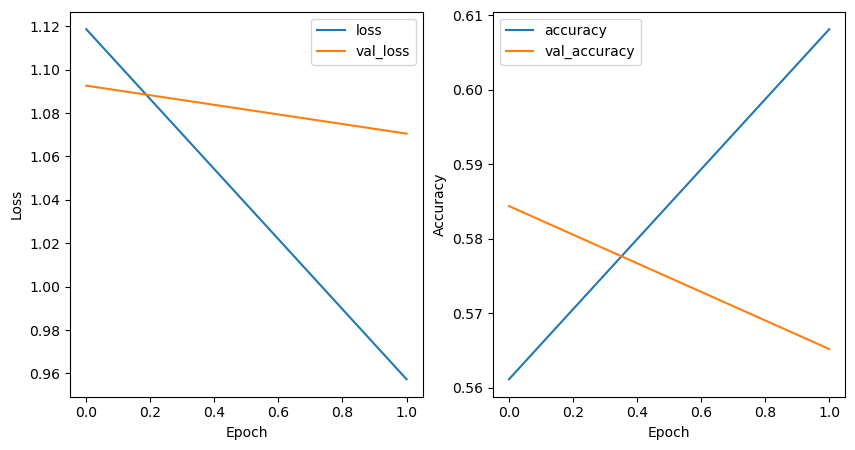

In [416]:
# Plotting the history 
metrics = history.history 
plt.figure(figsize=(10, 5)) 
    
# Plotting training and validation loss 
plt.subplot(1, 2, 1) 
plt.plot(history.epoch, metrics['loss'], metrics['val_loss']) 
plt.legend(['loss', 'val_loss']) 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
    
# Plotting training and validation accuracy 
plt.subplot(1, 2, 2) 
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy']) 
plt.legend(['accuracy', 'val_accuracy']) 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')

In [417]:
print(rnn.evaluate(X_test, y_test, verbose=1))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5605 - loss: 1.0750
[1.0704972743988037, 0.5651999711990356]


In [418]:
print(classification_report(df['overall_total'],df['sentiment']))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.31      0.18      0.23      1706
           2       0.12      0.14      0.13      1415
           3       0.18      0.13      0.15      2687
           4       0.22      0.29      0.25      5241
           5       0.66      0.63      0.64     13951

    accuracy                           0.45     25000
   macro avg       0.25      0.23      0.23     25000
weighted avg       0.46      0.45      0.45     25000



/Users/jackdamhorst/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jackdamhorst/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jackdamhorst/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
